Eğitim seti tarih aralığı: 2024-03-31 00:00:00 to 2025-06-30 00:00:00
Test seti tarihi: DatetimeIndex(['2025-07-31'], dtype='datetime64[ns]', name='Tarih', freq='ME')


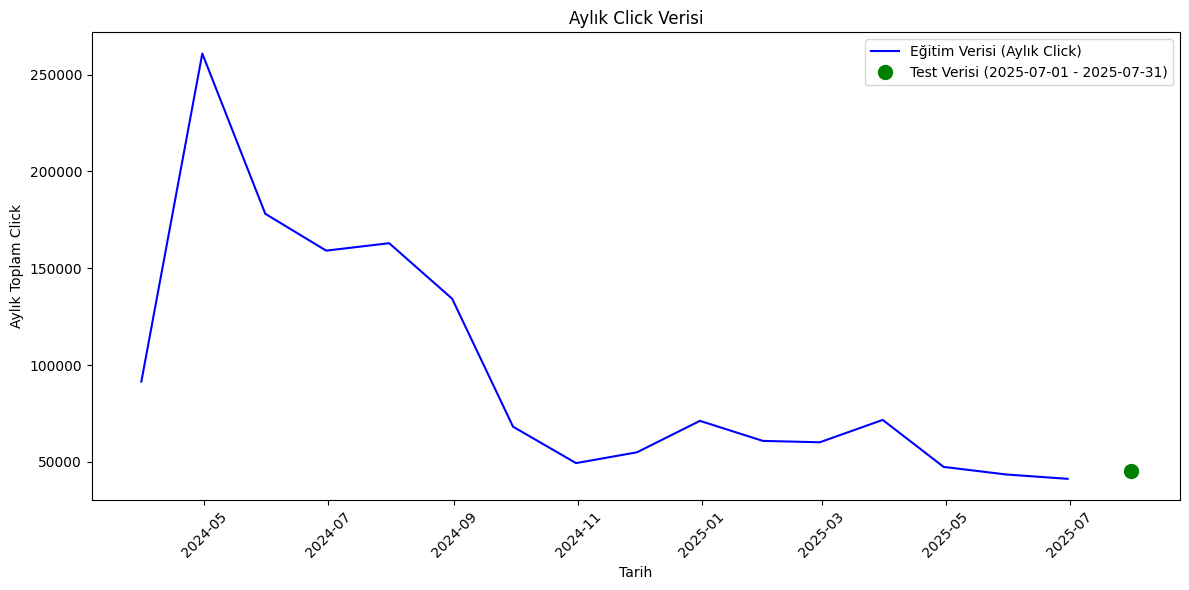

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=88.051, Time=0.25 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=83.269, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=82.333, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=82.957, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=83.699, Time=0.07 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=80.710, Time=0.04 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=82.708, Time=0.10 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.03 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=82.707, Time=0.07 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=84.052, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=82.710, Time=0.05 s

C:\Users\oguyildi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\oguyildi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


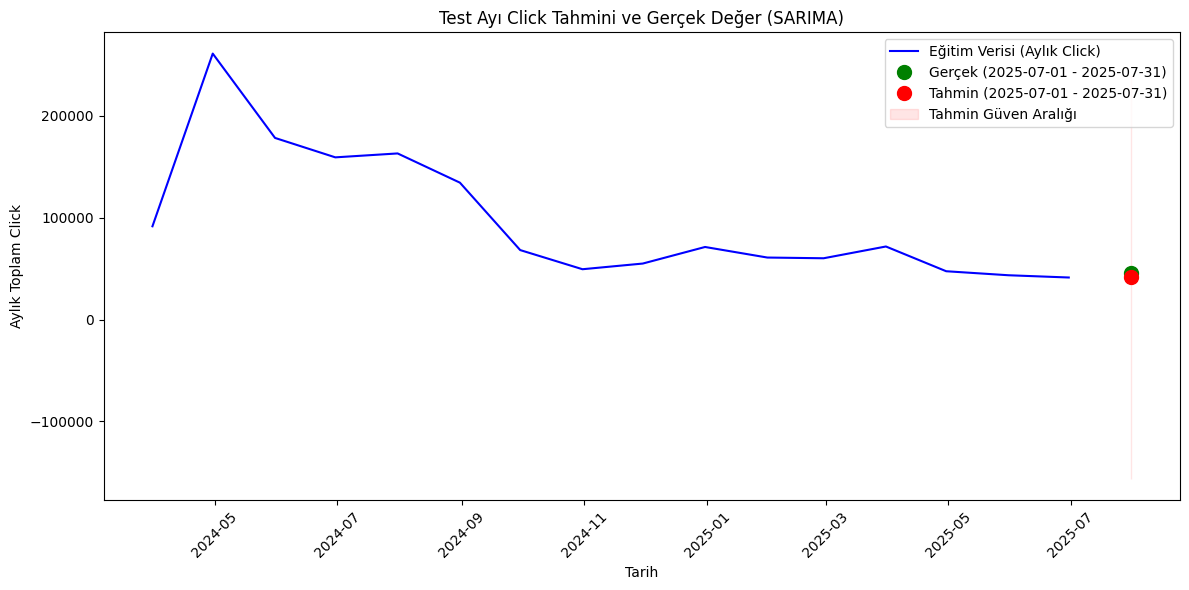

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error
import numpy as np

# Veriyi yükleme
df = pd.read_excel(r"C:\Users\oguyildi\OneDrive - Publicis Groupe\Desktop\Datawork\SEO Forecast\Herkes İçin Güzellik Son 16 Ay Verileri.xlsx")
data = df.copy()

# Veri temizleme
data['CTR'] = data['CTR'].str.replace('%', '', regex=False).astype(float) / 100
data = data.sort_values('Tarih')

def excel_tarihini_sayiya_cevir(deger):
    try:
        return float(str(deger).replace(',', '.'))
    except (ValueError, TypeError):
        try:
            tarih_obj = pd.to_datetime(deger, dayfirst=True)
            return float(f"{tarih_obj.day}.{tarih_obj.month}")
        except:
            return None

data['Ortalama Pozisyon'] = data['Ortalama Pozisyon'].apply(excel_tarihini_sayiya_cevir)
if data['Ortalama Pozisyon'].isnull().sum() > 0:
    data['Ortalama Pozisyon'].fillna(method='ffill', inplace=True)

# Veriyi aylık toplulaştırma
data['Tarih'] = pd.to_datetime(data['Tarih'])
data_sarima = data.set_index('Tarih').resample('ME').agg({'Click': 'sum'})
data_sarima = data_sarima.dropna()

# Test ayını seçme (2025-07-01 - 2025-07-31, ay sonu 2025-07-31)
test_date = pd.to_datetime('2025-07-31')
test = data_sarima.loc[data_sarima.index == test_date, 'Click']

# Test setinin boş olup olmadığını kontrol etme
if test.empty:
    print(f"Hata: Test ayı ({test_date}) veri setinde bulunamadı. Veri setindeki tarihler:")
    print(data_sarima.index)
    raise ValueError(f"Test ayı ({test_date}) veri setinde yok. Lütfen başka bir ay seçin.")

train = data_sarima.loc[data_sarima.index < test_date, 'Click']  # Test ayından önceki veriler

# Eğitim ve test seti tarihlerini kontrol etme
print("Eğitim seti tarih aralığı:", train.index.min(), "to", train.index.max())
print("Test seti tarihi:", test.index)

# Mevsimsellik analizi için veriyi görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Eğitim Verisi (Aylık Click)', color='blue')
plt.plot(test.index, test, 'go', label='Test Verisi (2025-07-01 - 2025-07-31)', markersize=10)
plt.title('Aylık Click Verisi')
plt.xlabel('Tarih')
plt.ylabel('Aylık Toplam Click')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Auto ARIMA ile en iyi parametreleri bulma
model = auto_arima(
    train, seasonal=True, m=12, stepwise=True, trace=True,
    max_p=3, max_q=3, max_P=2, max_Q=2, d=1, D=1, suppress_warnings=True
)

# SARIMA modelini kurma
sarima_model = SARIMAX(train, order=model.order, seasonal_order=model.seasonal_order)
sarima_fit = sarima_model.fit(disp=False)

# Test ayı için tahmin
forecast = sarima_fit.get_forecast(steps=1)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Test seti karşılaştırması
compare_df = pd.DataFrame({
    'Gerçek': test,
    'Tahmin': forecast_mean,
    'Mutlak Hata': abs(test - forecast_mean),
    'Yüzdelik Fark (%)': abs((test - forecast_mean) / test) * 100
})
print("\nTest Ayı (2025-07-01 - 2025-07-31) Karşılaştırması:")
print(compare_df.round(2))
print(f"\nMutlak Hata (MAE): {mean_absolute_error(test, forecast_mean):.2f}")

# Tahmin görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Eğitim Verisi (Aylık Click)', color='blue')
plt.plot(test.index, test, 'go', label='Gerçek (2025-07-01 - 2025-07-31)', markersize=10)
plt.plot(test.index, forecast_mean, 'ro', label='Tahmin (2025-07-01 - 2025-07-31)', markersize=10)
plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], 
                 color='red', alpha=0.1, label='Tahmin Güven Aralığı')
plt.title('Test Ayı Click Tahmini ve Gerçek Değer (SARIMA)')
plt.xlabel('Tarih')
plt.ylabel('Aylık Toplam Click')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Eğitim seti tarih aralığı: 2024-03-31 00:00:00 to 2025-06-30 00:00:00
Test seti tarihi: DatetimeIndex(['2025-07-31'], dtype='datetime64[ns]', name='Tarih', freq='ME')


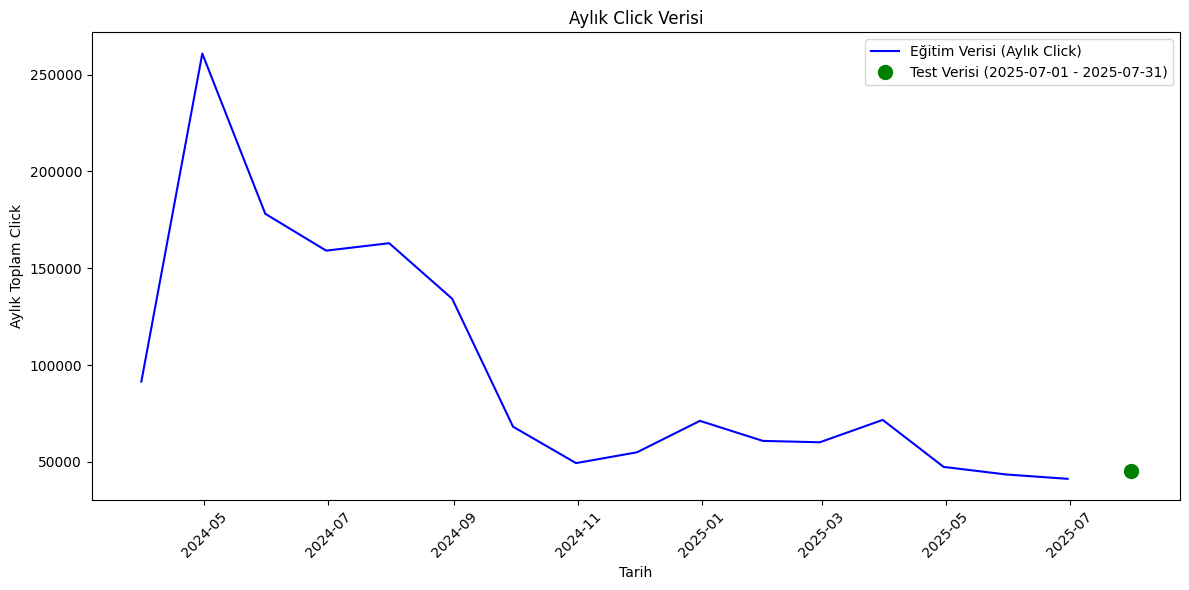

ValueError: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
import numpy as np

# Veriyi yükleme
df = pd.read_excel(r"C:\Users\oguyildi\OneDrive - Publicis Groupe\Desktop\Datawork\SEO Forecast\Herkes İçin Güzellik Son 16 Ay Verileri.xlsx")
data = df.copy()

# Veri temizleme
data['CTR'] = data['CTR'].str.replace('%', '', regex=False).astype(float) / 100
data = data.sort_values('Tarih')

def excel_tarihini_sayiya_cevir(deger):
    try:
        return float(str(deger).replace(',', '.'))
    except (ValueError, TypeError):
        try:
            tarih_obj = pd.to_datetime(deger, dayfirst=True)
            return float(f"{tarih_obj.day}.{tarih_obj.month}")
        except:
            return None

data['Ortalama Pozisyon'] = data['Ortalama Pozisyon'].apply(excel_tarihini_sayiya_cevir)
if data['Ortalama Pozisyon'].isnull().sum() > 0:
    data['Ortalama Pozisyon'].fillna(method='ffill', inplace=True)

# Veriyi aylık toplulaştırma
data['Tarih'] = pd.to_datetime(data['Tarih'])
data_sarima = data.set_index('Tarih').resample('ME').agg({'Click': 'sum'})
data_sarima = data_sarima.dropna()

# Test ayını seçme (2025-07-01 - 2025-07-31, ay sonu 2025-07-31)
test_date = pd.to_datetime('2025-07-31')
test = data_sarima.loc[data_sarima.index == test_date, 'Click']

# Test setinin boş olup olmadığını kontrol etme
if test.empty:
    print(f"Hata: Test ayı ({test_date}) veri setinde bulunamadı. Veri setindeki tarihler:")
    print(data_sarima.index)
    raise ValueError(f"Test ayı ({test_date}) veri setinde yok. Lütfen başka bir ay seçin.")

train = data_sarima.loc[data_sarima.index < test_date, 'Click']

# Eğitim ve test seti tarihlerini kontrol etme
print("Eğitim seti tarih aralığı:", train.index.min(), "to", train.index.max())
print("Test seti tarihi:", test.index)

# Mevsimsellik analizi için veriyi görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Eğitim Verisi (Aylık Click)', color='blue')
plt.plot(test.index, test, 'go', label='Test Verisi (2025-07-01 - 2025-07-31)', markersize=10)
plt.title('Aylık Click Verisi')
plt.xlabel('Tarih')
plt.ylabel('Aylık Toplam Click')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ETS modelini kurma
ets_model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12).fit()

# Test ayı için tahmin
ets_forecast = ets_model.forecast(steps=1)

# Test seti karşılaştırması
compare_df = pd.DataFrame({
    'Gerçek': test,
    'Tahmin': ets_forecast,
    'Mutlak Hata': abs(test - ets_forecast),
    'Yüzdelik Fark (%)': abs((test - ets_forecast) / test) * 100
})
print("\nTest Ayı (2025-07-01 - 2025-07-31) Karşılaştırması (ETS):")
print(compare_df.round(2))
print(f"\nMutlak Hata (MAE): {mean_absolute_error(test, ets_forecast):.2f}")

# Tahmin görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Eğitim Verisi (Aylık Click)', color='blue')
plt.plot(test.index, test, 'go', label='Gerçek (2025-07-01 - 2025-07-31)', markersize=10)
plt.plot(test.index, ets_forecast, 'ro', label='Tahmin (2025-07-01 - 2025-07-31)', markersize=10)
plt.title('Test Ayı Click Tahmini ve Gerçek Değer (ETS)')
plt.xlabel('Tarih')
plt.ylabel('Aylık Toplam Click')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()